## Modeling

Give our sample with many features (hard to scale on KNN) that are not all independent (hard to make naive bayes assumption), let's start with logistic regression.

In [2]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import numpy as np

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
#from visualize import generate_moons_df, preprocess, plot_boundaries

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, roc_curve

In [3]:
model_ready = pd.read_pickle('model_ready.pickle')
model_ready

,id,sex,birth_year,sample_type,race,poverty,marriage,metro_area,child_at_home,degree_other,house_type_30,fin_assets_30,debts_30,income_wage_compiled,income_bus_compiled
0,4,2,1981,1,2,179,2,3,1,2,6,0,0,4,0
1,5,1,1982,1,2,871,3,3,2,2,1,144000,9000,6,0
2,6,2,1982,1,2,226,3,3,2,2,6,3500,1000,3,0
3,10,1,1984,1,4,906,3,3,1,4,6,185000,96500,5,0
4,11,2,1982,1,2,399,3,3,1,4,6,3000,62500,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3773,9013,1,1982,0,1,140,2,3,0,1,6,1750,0,3,0
3774,9015,2,1980,0,1,325,3,2,3,2,1,88176,55464,5,0
3775,9018,2,1980,1,4,327,3,2,0,1,6,100,1200,3,0
3776,9019,1,1984,0,2,498,2,3,0,3,6,400,17000,4,0


In [3]:
model_ready.columns

Index(['id', 'sex', 'birth_year', 'sample_type', 'race', 'poverty', 'marriage',
       'metro_area', 'child_at_home', 'degree_other', 'house_type_30',
       'fin_assets_30', 'debts_30', 'income_wage_compiled',
       'income_bus_compiled'],
      dtype='object')

### FSM: Financial Features

#### Let's start with our FSM metics--only the financial metrics. 
#### 'id', 
#'sex', \
#'birth_year', \
#### 'sample_type', \
#'race', 
#### 'poverty', 
#'marriage', \
#'metro_area', \
#'child_at_home', \
#'degree_other', 
#### 'house_type_30', 
#### 'fin_assets_30', 
#### 'debts_30', 
#### 'income_wage_compiled' 
#### 'income_bus_compiled' 

Poverty Ratio= A ratio comparing the gross household income variable (rounds 1-7) or the gross family income variable (rounds 8 and up) to the federal poverty level for previous year, taking household size into account. \
Any number above 1 means the family is above the poverty threshold. \
The higher the number, the more wealthy the family is compared to the the federal poverty level. \

The ratio was transformed by the study into integers, but let's tranform them back into floats.

In [4]:
#checking for negative values
model_ready[model_ready['poverty'] < 0]

,id,sex,birth_year,sample_type,race,poverty,marriage,metro_area,child_at_home,degree_other,house_type_30,fin_assets_30,debts_30,income_wage_compiled,income_bus_compiled


In [5]:
model_ready['poverty'] = model_ready['poverty'].apply(lambda x: float(x/100))

In [6]:
model_ready.dtypes

id                        int64
sex                       int64
birth_year                int64
sample_type               int64
race                      int64
poverty                 float64
marriage                  int64
metro_area                int64
child_at_home             int64
degree_other              int64
house_type_30             int64
fin_assets_30             int64
debts_30                  int64
income_wage_compiled      int64
income_bus_compiled       int64
dtype: object

We want to do a binary classification, so we have to extract the owner/not owner boolean from our house_type_30 column

House Type Key:\
1='House' \
2='Ranch/Farm' \
3='Mobile Home'\
6='R does not own'\
9='Owns other residence type'

In [7]:
model_ready.house_type_30.value_counts()

6    1970
1     968
9      98
3      76
2       1
Name: house_type_30, dtype: int64

In [8]:
model_ready.house_type_30.isnull().sum()

0

In [9]:
def owns_house(house_type):
    '''Takes in house_type_30 code and exports a boolean, 1 for owned home, regardless of type and 0 for rental home'''
    if house_type == 6:
        return 0
    else:
        return 1

In [10]:
#create new column--our y variable--for binary classification.
model_ready['homeowner'] = model_ready['house_type_30'].apply(lambda x: owns_house(x))

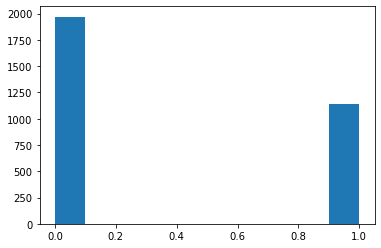

In [11]:
#we can see that our values aren't fully balanced. This is good to keep in mind 
#for classification metric interpretation and the precision recall tradeoff.
plt.hist(model_ready['homeowner']);

In [12]:
#pickle this dataframe
model_ready.to_pickle('model_ready_fsm')

In [2]:
model_ready = pd.read_pickle('model_ready_fsm')

In [3]:
#create new df with only financial values for our FSM and id.
model_0 = model_ready[['id', 'poverty', 'homeowner', 'fin_assets_30', 'debts_30', 'income_wage_compiled', 'income_bus_compiled']]



In [4]:
model_0

,id,poverty,homeowner,fin_assets_30,debts_30,income_wage_compiled,income_bus_compiled
0,4,1.79,0,0,0,4,0
1,5,8.71,1,144000,9000,6,0
2,6,2.26,0,3500,1000,3,0
3,10,9.06,0,185000,96500,5,0
4,11,3.99,0,3000,62500,4,0
...,...,...,...,...,...,...,...
3773,9013,1.40,0,1750,0,3,0
3774,9015,3.25,1,88176,55464,5,0
3775,9018,3.27,0,100,1200,3,0
3776,9019,4.98,0,400,17000,4,0


In [61]:
model_0.to_pickle('model_financial.pickle')

### Logistic Regression - Financial Features Only

In [5]:
features = ['poverty', 'fin_assets_30', 'debts_30', 'income_wage_compiled', 'income_bus_compiled']

X = model_0.loc[:, features]
y = model_0['homeowner']

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=3)

In [8]:
#set up logistic regression cross validation
#set balanced class weights--since we know our classes are imbalanced.
lr_cv = LogisticRegressionCV(class_weight = 'balanced')

#Scale data
ss = StandardScaler()
#fit transform X train
X_train_scaled = ss.fit_transform(X_train)
#fit X val
X_val_scaled = ss.transform(X_val)

#fit the X train on logiscitc regression cv model
lr_cv.fit(X_train_scaled, y_train)

print(f'Logistic Regression TRAIN accuracy: {lr_cv.score(X_train_scaled, y_train):.5f}')
print(f'Logistic Regression VAL accuracy: {lr_cv.score(X_val_scaled, y_val):.5f}')

Logistic Regression TRAIN accuracy: 0.70166
Logistic Regression VAL accuracy: 0.71910


In [9]:
y_preds = lr_cv.predict(X_val_scaled)

print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       413
           1       0.58      0.59      0.58       210

    accuracy                           0.72       623
   macro avg       0.69      0.69      0.69       623
weighted avg       0.72      0.72      0.72       623



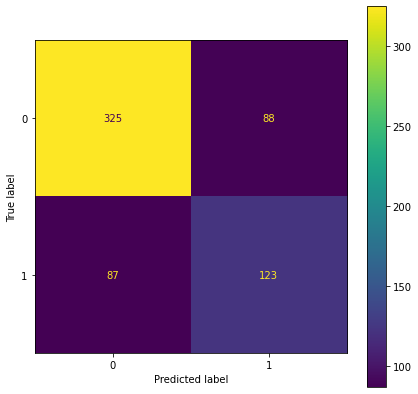

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr_cv, X_val_scaled, y_val, ax=ax);

We're seeing a balanced matrix, with an almost equal amount of false negatives and positives.\
Our precision and recall are very balanced.

### Test

In [11]:
#set up logistic regression cross validation
#set balanced class weights--since we know our classes are imbalanced.
lr = LogisticRegression(class_weight = 'balanced')

#Scale data
ss = StandardScaler()
#fit transform X train
X_train_val_scaled = ss.fit_transform(X_train_val)
#fit X val
X_test_scaled = ss.transform(X_test)

#fit the X train on logiscitc regression cv model
lr.fit(X_train_val_scaled, y_train_val)

print(f'Logistic Regression TRAIN-VAL accuracy: {lr.score(X_train_val_scaled, y_train_val):.5f}')
print(f'Logistic Regression TEST accuracy: {lr.score(X_test_scaled, y_test):.5f}')

Logistic Regression TRAIN-VAL accuracy: 0.70281
Logistic Regression TEST accuracy: 0.72392


In [12]:
y_preds_test = lr.predict(X_test_scaled)

print(classification_report(y_test, y_preds_test))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       400
           1       0.60      0.68      0.64       223

    accuracy                           0.72       623
   macro avg       0.70      0.71      0.71       623
weighted avg       0.73      0.72      0.73       623



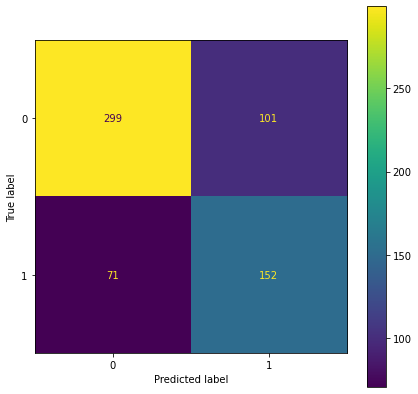

In [13]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(lr, X_test_scaled, y_test, ax=ax);

#### Let's plot the ROC curve and look at AUC in order to determine more about model effectiveness, compared to our KNN model in our other notebook (Model-KNN)

<Figure size 1080x1080 with 0 Axes>

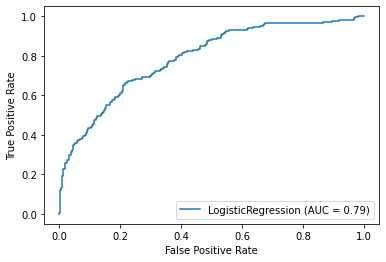

In [36]:
plt.figure(figsize=(15, 15))
plot_roc_curve(lr, X_test_scaled, y_test)
plt.show();


### Look at predictions

In [25]:
X_test_pred_df = X_test.copy()

In [27]:
#add in new column for our predictions
X_test_pred_df['homeowner_pred'] = y_preds_test

,poverty,fin_assets_30,debts_30,income_wage_compiled,income_bus_compiled,homeowner_pred,homeowner
3391,10.48,135000,0,6,0,1,0
1289,5.44,17000,46000,5,0,1,1
226,3.29,1000,2000,3,0,0,0
375,2.54,600,24200,5,0,1,0
487,5.88,27000,0,6,0,1,0
...,...,...,...,...,...,...,...
3003,0.54,2600,80164,2,0,0,0
2853,1.04,1920,0,3,2,0,0
1300,0.47,365,7000,1,0,0,0
1284,2.34,1000,0,4,0,0,0


In [29]:
#add back in our actual Y values
X_test_pred_df = X_test_pred_df.join(y_test)

In [31]:
false_positives = X_test_pred_df[(X_test_pred_df['homeowner_pred'] == 1) & (X_test_pred_df['homeowner'] == 0)]
false_positives.describe()

,poverty,fin_assets_30,debts_30,income_wage_compiled,income_bus_compiled,homeowner_pred,homeowner
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.0
mean,5.728911,31661.247525,36087.772277,4.871287,0.158416,1.0,0.0
std,4.562888,34199.560246,49411.290676,0.757144,0.758059,0.0,0.0
min,1.030000,0.000000,0.000000,2.000000,0.000000,1.0,0.0
25%,3.420000,9200.000000,6000.000000,4.000000,0.000000,1.0,0.0
50%,4.710000,20000.000000,24000.000000,5.000000,0.000000,1.0,0.0
75%,6.190000,38000.000000,44000.000000,5.000000,0.000000,1.0,0.0
max,23.030000,160000.000000,360000.000000,6.000000,5.000000,1.0,0.0


In [30]:
false_negatives = X_test_pred_df[(X_test_pred_df['homeowner_pred'] == 0) & (X_test_pred_df['homeowner'] == 1)]
false_negatives.describe()

,poverty,fin_assets_30,debts_30,income_wage_compiled,income_bus_compiled,homeowner_pred,homeowner
count,71.000000,71.000000,71.00000,71.000000,71.000000,71.0,71.0
mean,3.758310,9776.915493,12668.28169,3.507042,0.239437,0.0,1.0
std,3.849758,15808.233463,15867.09108,1.132295,0.932964,0.0,0.0
min,0.050000,0.000000,0.00000,0.000000,0.000000,0.0,1.0
25%,2.055000,700.000000,0.00000,3.000000,0.000000,0.0,1.0
50%,2.880000,3800.000000,7000.00000,4.000000,0.000000,0.0,1.0
75%,4.125000,10000.000000,17000.00000,4.000000,0.000000,0.0,1.0
max,23.030000,88000.000000,71800.00000,5.000000,6.000000,0.0,1.0
